# Create artifact from time series dataframe

In [1]:
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

### Notebook config

In [2]:
base_path = Path.home()

In [3]:
config = AttrDict(
    artifact_name = 'toit_piazza_vanvitelli', # Name of the artifact to be created
    data_fpath = base_path/'data/modal/ToIT_dataset_nuovo2.pickle', # Name of the data file. Must be a pickle file
    data_cols = [9], # Put here the idxs of the columns of interest ([] for all)
    freq = '1h', # Frequency of the data. (cannot be None). It can be used to force a sampling freq to data without an index
    # See offset aliases in https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
    joining_validation_test = False, #True to create an artifact linking validation and testing data or False if it doesn't
    missing_values_technique='linear_interpolation', # handle missing values technique
    normalize_training = False,
    # training, validation and testing days
    range_training = None, # in days. Set to None for full dataset
    range_validation = None, # in days. Set to None for validation=training
    range_testing = None,  # in days. Set to None for no training
    resampling_freq = None, # resampling frequency
    start_date = None, # in format dd/mm/yyyy. Set to None for default start date (01/01/1970)
    time_col = None, # Put here the idx of the column containing the timestamp, if any (e.g. 0 for taxi)
    use_wandb = True, # Whether to use or not wandb for experiment tracking
    wandb_artifacts_path = 'data/wandb_artifacts', # Output path where the resulting TSArtifact will be stored
)

In [4]:
# Default date format
date_format = "%d/%m/%Y"

### Run

For the experiment tracking and hyperparameter we will use the tool **Weights & Biases**. 

Before running this notebook part, make sure you have the `$WANDB_API_KEY` environment varibale defined with your API_KEY (run in a terminal `echo $WANDB_API_KEY` to see it). If not, run in a terminal `wandb login [API_KEY]`. You can see your API_KEY [here](https://wandb.ai/authorize) or in the settings of your W&B account.

In [5]:
# IMPORTANT! --> use wandb.init(..., mode='disabled', ...) to test W&B API without uploading anything to the clouds
run = wandb.init(entity = os.environ['WANDB_ENTITY'], 
                 project=os.environ['WANDB_PROJECT'], 
                 job_type='create_dataset', 
                 resume=True,
                 mode='online' if config.use_wandb else 'disabled',
                 config=config)
config = run.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vrodriguezf90 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


#### Data Extraction

The data is assumed to come as a dataframe, either as a binarized  picke file or
as a csv file. It can also come as a `.tsf` file

In [6]:
ext = str(config.data_fpath).split('.')[-1]
if ext == 'pickle':
    f = open(config.data_fpath, 'rb')
    bin_data = f.read()
    df = pickle.loads(bin_data)
elif ext == 'csv':
    df = pd.read_csv(config.data_fpath)
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(config.data_fpath)
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = '%Y-%m-%d'
    df = pd.DataFrame(stack_pad(data.series_value).T)
else:
    raise Exception('The data file path has an unsupported extension')
print(f'File loaded successfully')
print(df.shape)
df.head()

File loaded successfully
(2099, 15)


,Napoli_temperatura,Napoli_vento,Napoli_pioggia,Caserta1_temperatura,Caserta1_vento,Caserta1_pioggia,Caserta2_temperatura,Caserta2_vento,Caserta2_pioggia,Piazza_Vanvitelli,Via_Riccardo_Filangieri_di_Candida_Gonzaga,Via_Turati,Via_Raffaele_Gasparri,Via_Giovanni_Patturelli,Via_Unita_Italiana
2019-12-04 13:00:00,3,4,0,3,3,0,3,3,0,0.364095,0.483254,0.137278,0.687272,0.370537,0.264795
2019-12-04 14:00:00,3,4,0,3,3,0,3,3,0,0.532166,0.472088,0.250818,0.641671,0.444153,0.259488
2019-12-04 15:00:00,3,3,0,2,3,0,2,3,0,0.661551,0.363333,0.394207,0.721937,0.687248,0.273713
2019-12-04 16:00:00,2,3,0,2,3,0,2,3,0,0.552637,0.313539,0.352666,0.551390,0.541144,0.192770
2019-12-04 17:00:00,2,3,0,2,3,0,2,2,0,0.684569,0.342028,0.366317,0.227151,0.275473,0.111944


Set the time columm (if any) as an index

In [7]:
if config.time_col is not None: df = df.set_index(pd.DatetimeIndex(df.iloc[:, config.time_col]), drop=False)
df.head()

,Napoli_temperatura,Napoli_vento,Napoli_pioggia,Caserta1_temperatura,Caserta1_vento,Caserta1_pioggia,Caserta2_temperatura,Caserta2_vento,Caserta2_pioggia,Piazza_Vanvitelli,Via_Riccardo_Filangieri_di_Candida_Gonzaga,Via_Turati,Via_Raffaele_Gasparri,Via_Giovanni_Patturelli,Via_Unita_Italiana
2019-12-04 13:00:00,3,4,0,3,3,0,3,3,0,0.364095,0.483254,0.137278,0.687272,0.370537,0.264795
2019-12-04 14:00:00,3,4,0,3,3,0,3,3,0,0.532166,0.472088,0.250818,0.641671,0.444153,0.259488
2019-12-04 15:00:00,3,3,0,2,3,0,2,3,0,0.661551,0.363333,0.394207,0.721937,0.687248,0.273713
2019-12-04 16:00:00,2,3,0,2,3,0,2,3,0,0.552637,0.313539,0.352666,0.551390,0.541144,0.192770
2019-12-04 17:00:00,2,3,0,2,3,0,2,2,0,0.684569,0.342028,0.366317,0.227151,0.275473,0.111944


In [8]:
df = infer_or_inject_freq(df, injected_freq=config.freq, 
                            start_date=config.start_date, format = date_format)
df.index.freq

<Hour>

Subset number of variables

In [9]:
if config.data_cols != []: df = df.iloc[:, config.data_cols]
print(f'Num. variables: {len(df.columns)}')

Num. variables: 1


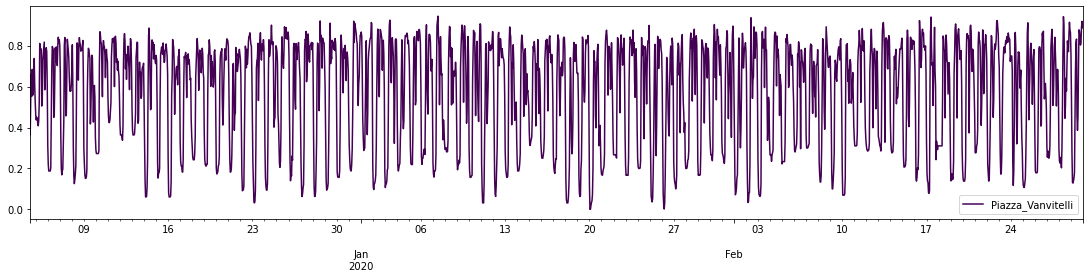

In [10]:
#slow
df.plot(subplots=True, figsize=(30,30), layout=(8,2),  sharex=True, colormap='viridis')
plt.tight_layout()

#### Data Transformation

##### 1. Handle Missing Values, Resample and Normalize
In this second part, Time Series Artifact (TSArtifact) object can be created and missing values handling techniques, resampling and normalization can be applied. This techniques should be applied on the three subsets that must be previously created: training, validation and testing.

In [11]:
# Training data
rg = config.range_training
df_training = df.query('index.dt.day.isin(@rg)') if rg is not None else df
training_artifact = TSArtifact.from_df(df_training, 
                                       name=config.artifact_name, 
                                       missing_values_technique=config.missing_values_technique,
                                       resampling_freq=config.resampling_freq, 
                                       normalize=config.normalize_training, 
                                       path=str(Path.home()/config.wandb_artifacts_path))
training_artifact.metadata

{'TS': {'sd': '2019-12-04 13:00:00',
  'ed': '2020-02-29 23:00:00',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 2099,
  'freq': '<Hour>',
  'vars': ['Piazza_Vanvitelli'],
  'hash': '-7395006572073929257'}}

In [12]:
# Validation data
rg = config.range_validation
df_validation = df.query('index.dt.day.isin(@rg)') if rg is not None else df_training
validation_artifact = TSArtifact.from_df(df_validation,
                                         name=config.artifact_name, 
                                         missing_values_technique=config.missing_values_technique,
                                         resampling_freq=config.resampling_freq, 
                                         normalize=False,
                                         path=str(Path.home()/config.wandb_artifacts_path))
validation_artifact.metadata

{'TS': {'sd': '2019-12-04 13:00:00',
  'ed': '2020-02-29 23:00:00',
  'created': 'from-df',
  'n_vars': 1,
  'handle_missing_values_technique': 'linear_interpolation',
  'has_missing_values': 'False',
  'n_samples': 2099,
  'freq': '<Hour>',
  'vars': ['Piazza_Vanvitelli'],
  'hash': '-7395006572073929257'}}

In [13]:
# Testing data
rg = config.range_testing
if rg is not None:
    df_testing = df.query('index.dt.day.isin(@rg)')
    testing_artifact = TSArtifact.from_df(df_testing,
                                      name=config.artifact_name, 
                                      missing_values_technique=config.missing_values_technique,
                                      resampling_freq=config.resampling_freq, 
                                      normalize=False,
                                      path=str(Path.home()/config.wandb_artifacts_path))
    testing_artifact.metadata
else: testing_artifact = None

In [14]:
# Validation + Testing data
if(config.joining_validation_test):
    val_test_range = list(config.range_validation) + list(config.range_testing)
    df_val_test = df.query('index.dt.day.isin(@val_test_range)')
    val_test_artifact = TSArtifact.from_df(df_val_test,
                                           name=config.artifact_name, 
                                           missing_values_technique=config.missing_values_technique,
                                           resampling_freq=config.resampling_freq, 
                                           normalize=False,
                                           path=str(Path.home()/config.wandb_artifacts_path))
    print(val_test_artifact.metadata)

#### Data Loading

In [15]:
# log the artifacts

run.log_artifact(training_artifact)
run.log_artifact(validation_artifact)
if testing_artifact: run.log_artifact(testing_artifact)
if(config.joining_validation_test):
    run.log_artifact(val_test_artifact)

In [16]:
run.finish()